# Automatically Grading Alternative Text on Twitter


## Motivation and Problem Statement

With the increase in emojis, videos, and images, Twitter and other social media platforms have become increasingly visual. However, this visual content is not accessible to people with vision impairments, excluding them from many current communication platforms. Different approaches have been leveraged to make visual content more accessible to blind users. One central element to current approaches involves providing textual descriptions (alternative text) to user-posted images. Platforms like Facebook and Instagram have used algorithms to automatically tag pictures with low-quality descirptions, Twitter encourages users to add their own descriptions for the images they post. 

To do so, the user first needs to turn on [the option in accessibility setting](https://help.twitter.com/en/using-twitter/picture-descriptions), where they need to check the "Compose image descriptions" option.

<img src="setting.png">

After the setting is set up, users have the option of composing image descriptions when they post an image. 

<img src="submit.png">

## Related Work

Alternative text was introuduced in the HTML specification in 1995 \[1\], and it was meant for users with non-graphical browsers to understand information that may be contained in images on the web. Users with vision impairments also use non-graphical browsers, including screen readers and Braille displays. 

The lack of alt text online has been a perennial problem since it's introduction. Bigham et al. found that only 37% of images on top websites contained alternative text \[2\]. A more recent study last year said that this had increaed to 50%, but that meant that 50
% of images are still inaccessible to people with vision imapirments \[3\].

However, these numbers are for the top sites on the web. The reality of accessibility on social media is much different. Through user interviews with blind Twitter users, Morris et al. found that Twitter was becoming more inaccessible with an increase in visual content \[4\]. It was originally a text-only site, which made it relatively easy to access via a screen-reader either on the web or a third-party application. Now, around 25% of tweets contain some sort of media, whether thats an image, video, or GIF. Other social networks are even worse: all content on Instagram, Snapchat, or TikTok is inaccessible. However, we focus on Twitter because there is already a blind userbase present.

Cole Gleason (one of the authors on this project) has previously conducted research in this area, and so we will re-use a dataset collected last year \[5\] for this analysis. We will describe how you could replicate this work by collecting a new dataset yourself.

## Required Dependencies

To run this project, in addition to standard data science tools like numpy and pandas, you will need the following packages:


*   python-twitter
*   spacy
*   py-torch
*   transformers
*   ftfy
*   treeinterpreter

You can install these individually, or use the cell below to install using pip in the current environment.

## Data Collection

We collect data from twitter using the [Twitter API](https://developer.twitter.com/en/docs), specificially by using the [python-twitter](https://python-twitter.readthedocs.io/en/latest) package. To use this API, you will need [Twitter access tokens](https://developer.twitter.com/en/docs/basics/authentication/guides/access-tokens). We store these in a file called config.py, which we load now. (Note to graders: if you need to borrow API access to grade this, please email cgleason@cs.cmu.edu). 

In [1]:
import twitter
# a file containing the API keys below.
from config import Config 

twitter_api = twitter.Api(consumer_key=Config.TWITTER_CONSUMER_KEY,
                  consumer_secret=Config.TWITTER_CONSUMER_SECRET,
                  access_token_key=Config.TWITTER_ACCESS_TOKEN_KEY,
                  access_token_secret=Config.TWITTER_ACCESS_TOKEN_SECRET,
                  tweet_mode='extended')

In [2]:
def random_sample_tweets(n=100):
  """
  Pulls from a 1% sample of Twitter, and returns a list of n tweets once collected.
  """
  random_sample = []
  for tweet in twitter_api.GetStreamSample():
    status = twitter.Status.NewFromJsonDict(tweet)
    if status.user: # some of the objects returned here are delete messages, which we don't want to save
      random_sample.append(status)
      if len(random_sample) >= n:
          break
  return random_sample

random_5 = random_sample_tweets(5)
for tweet in random_5:
  if tweet.user:
    print(f"{tweet.user.screen_name} tweeted: {tweet.text}")

SaudTheMonster tweeted: الايموت يجسد ردة فعلي ههههههههههههههههههههههههههههههههههههههههههههه

https://t.co/fc0lxQyzOz https://t.co/Vfouveml4Y
myplacepromised tweeted: くりまたすみって学校へ行こうだっけ、なんかすごい記憶にある。
mly__gr tweeted: 日プをきっかけに応援広告で応援するっていうことが増えて欲しいし、応援素材を運営側が提供することでファンにとっても運営にとっても利益につながるってことを改めて思った &gt;RT
Pawiz tweeted: Acaba de pasar la maravilla más maravillosa: mi vecino me compartió su internet...

GRATIS 💕
wandaarroy0000 tweeted: RT @hinchadeduki: decime te amo o me drogo porfavor


### Retrieving Tweets from a Specific User


We might instead wish to collect the tweets from a specific user. This function will collect N tweets given a specific username, or all avalable tweets if None it passed instead.

In [81]:
# if None is passed as the count parameter, we will retrieve all available tweets

def get_user_tweets(screenname, n=100):
    if n == None:
        remaining = 200
    else:
        remaining = n
    max_id = None
    rv = []
    while remaining > 0:
        tweets = twitter_api.GetUserTimeline(screen_name=screenname, count=remaining,
                                             exclude_replies=True, max_id=max_id)
        if len(tweets) == 0:
            break
        if n:
            remaining -= len(tweets)
        rv.extend(tweets)
        max_id = tweets[-1].id_str
    return rv

Let's try this out on the Twitter account for SCS.

In [5]:
# By passing None we will get all available tweets.
tweets = get_user_tweets('SCSatCMU', n=None)
print(f"Collected {len(tweets)} tweets.")
print("Oldest tweet found: ", tweets[-1].full_text)

Collected 3223 tweets.
Oldest tweet found:  Carnegie Mellon @nrec_cmu CHIMP robot will make rare appearance @projectolympus Show&amp;Tell Apr 14 https://t.co/NwjQbGdMwM


## Descriptive Statistics of Dataset
The prior Twitter alt-text dataset was collected in June 2018, and consists of tweets samples for approximately 6 hours per day over 5 days \[5\]. Of 9.22M tweets sampled, 1.09 million tweets that contain images.  Given that this dataset is large (i.e., each day's .txt file is ~2Gb), we will show the process of our data processing using data from a single day. Later we will be using pre-procssed dataset for more detailed illustration.  

In [4]:
import json
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
%matplotlib inline

In [8]:
#Let's take a look at what we've crawlled from Twitter API
with open("tweets_1.txt") as myfile:
    head = myfile.readlines()
json.loads(head[1][:-1])

{'contributors': None,
 'coordinates': None,
 'created_at': 'Fri Jun 15 15:27:35 +0000 2018',
 'display_text_range': [0, 93],
 'entities': {'hashtags': [],
  'media': [{'display_url': 'pic.twitter.com/pw1YLs3eX1',
    'expanded_url': 'https://twitter.com/Agarie/status/1007631788729094144/photo/1',
    'id': 1007631668654559200,
    'id_str': '1007631668654559232',
    'indices': [70, 93],
    'media_url': 'http://pbs.twimg.com/media/DfvTqfqW0AASdtb.jpg',
    'media_url_https': 'https://pbs.twimg.com/media/DfvTqfqW0AASdtb.jpg',
    'sizes': {'large': {'h': 487, 'resize': 'fit', 'w': 781},
     'medium': {'h': 487, 'resize': 'fit', 'w': 781},
     'small': {'h': 424, 'resize': 'fit', 'w': 680},
     'thumb': {'h': 150, 'resize': 'crop', 'w': 150}},
    'source_status_id': 1007631788729094100,
    'source_status_id_str': '1007631788729094144',
    'source_user_id': 48620930,
    'source_user_id_str': '48620930',
    'type': 'photo',
    'url': 'https://t.co/pw1YLs3eX1'}],
  'symbols': [],

In [43]:
# We collected 6 batches of data and named them as 1-6
# We load them the following way
twitter_count = 0
alt_text = []
for x in range(1,6):
    with open("tweets_"+ str(x) + ".txt") as myfile:
        head = myfile.readlines()
        twitter_count = twitter_count + len(head)
        for h in range(len(head)):
            t = json.loads(head[h][:-1])
            try:
                atl = t["extended_entities"]['media'][0]['ext_alt_text']  #get alt_tags
                if atl != None:
                    alt_text = alt_text + [t]
            except:
                pass

In [45]:
print("The number of Tweets we have collected:",twitter_count)

The number of Tweets we have collected: 1091875


In [24]:
#After the previous step, we have obtained a pickle file contained 
import pickle
alt_text = pickle.load( open( "alt_text_final.p", "rb" ) )

In [25]:
# the length of alt text without any filtering
len(alt_text)


1143

In [33]:
# We can print them out to have an impression about what the alt_texts are about
for x in range (0,100):
    print (alt_text[x]['extended_entities']['media'][0]['ext_alt_text'])

https://www.flickr.com/photos/maevalecoq/
Suruç’da hastanede kameralar tahrip edilmiş, saldırı planlı görünüyor!
http://contemporary-art-blog.tumblr.com/post/21933515681
Image
http://www.designboom.com/architecture/moon-hoon-interview-10-24-2014/
Obama, Luis and your friend Lin
http://archillect.com
北と南の方角を示すイラスト。真ん中に十字模様があり、北にホッキョクグマ、南にペンギンが描かれている。
http://an-addled-mind.tumblr.com/post/99323224073
Girl posing In front of the blue YSL majorelle house in Morocco with a straw hat on
http://archillect.com
http://archillect.com
Obama, Luis and your friend Lin
https://www.flickr.com/photos/maevalecoq/
Tony Hawk's Existential Nightmare (PS2, 2018)
http://archillect.com
Obama, Luis and your friend Lin
“How to talk to the landlord:” left: says “no” above a happy landlord talking to a single tenant right: says “yes” above a sad landlord talking to a group of tenants
Imagem de pinos usados para colocar cocaína decorados com bandeiras de alguns dos países participantes da Copa do Mundo de 2018
Ob

In [35]:
# We can see that, there are a lot of urls (which are automatically generated by flicker, tumblr or archilletct)
# and non-English words that are not fit for our data processing.
# In these steps, we need to filter these out. 

In [34]:
#We define a helper method to help us filter out the eurls 
def find_url(string): 
    url = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', string) 
    return url

In [41]:
alt_filter_url = []

for a in alt_text:
    atl = a["extended_entities"]['media'][0]['ext_alt_text'] 
    if find_url(atl) == []:
        alt_filter_url = alt_filter_url + [a]
print("Number of alt_tags after filtrering out URLs:", len(alt_filter_url))

Number of alt_tags after filtrering out URLs: 505


In [46]:
#We then usea module called langdetect to detect English Tweets

from langdetect import detect

alt_filter_english = []

for a in alt_filter_url:
    atl = a["extended_entities"]['media'][0]['ext_alt_text'] 
    try:
        if detect(atl) == 'en':
            alt_filter_english = alt_filter_english + [a]
    except:
        pass
print("Number of alt_tags after filtrering out URLs and non-English Tweets :", len(alt_filter_english))

Number of alt_tags after filtrering out URLs and non-English Tweets : 316


In [48]:
alt_filter_english

[{'contributors': None,
  'coordinates': None,
  'created_at': 'Fri Jun 15 00:19:34 +0000 2018',
  'display_text_range': [0, 76],
  'entities': {'hashtags': [],
   'media': [{'display_url': 'pic.twitter.com/13mccDFPJM',
     'expanded_url': 'https://twitter.com/Lin_Manuel/status/1007383593725947906/photo/1',
     'id': 1007383355313147900,
     'id_str': '1007383355313147905',
     'indices': [53, 76],
     'media_url': 'http://pbs.twimg.com/media/Dfrx0wYU0AEcih8.jpg',
     'media_url_https': 'https://pbs.twimg.com/media/Dfrx0wYU0AEcih8.jpg',
     'sizes': {'large': {'h': 1198, 'resize': 'fit', 'w': 2048},
      'medium': {'h': 702, 'resize': 'fit', 'w': 1200},
      'small': {'h': 398, 'resize': 'fit', 'w': 680},
      'thumb': {'h': 150, 'resize': 'crop', 'w': 150}},
     'source_status_id': 1007383593725947900,
     'source_status_id_str': '1007383593725947906',
     'source_user_id': 79923701,
     'source_user_id_str': '79923701',
     'type': 'photo',
     'url': 'https://t.co/13

In [51]:
# We tried to see the distribution of these posts. 

from collections import Counter

alt_user = []
for a in alt_filter_english:
    alt_user = [a['user']['id']] + alt_user
unique_alt_user =  list((set(alt_user)))
dict_count = dict.fromkeys(unique_alt_user,0)
for a in alt_filter_english:
    user_id = a['user']['id']
    dict_count[user_id] = dict_count[user_id] + 1
Counter(dict_count.values())

#Most users only post one Tweeet that contains Atl-tages. 

Counter({1: 278, 2: 4, 5: 1, 3: 1, 7: 2, 4: 2})

In [54]:
# We then check their numbere of followers 
follower_count = []
for a in alt_filter_english:
    follower_count = follower_count + [a['user']['followers_count']]
follower_count.sort()

In [72]:
id_follower = []
processed_id = []
for a in alt_filter_english:
    follower = a['user']['followers_count']
    user_name = a['user']['screen_name']
    user_id = a['user']['id']
    status_count = a['user']['statuses_count']
    if user_id not in processed_id:
            processed_id = [user_id] + processed_id    
            id_follower = id_follower + [[user_name,user_id,follower,status_count]]

In [74]:
import pandas as pd
df = pd.DataFrame(data=id_follower)
df.columns =['user_name', 'user_id','num_of_followers','status_count'] 

In [75]:
df.sort_values(by=['num_of_followers'],ascending=False).head(10)

,user_name,user_id,num_of_followers,status_count
139,SmarterTravel,14132853,311978,32597
210,MisfitsGG,3182089458,59583,6939
175,netstartraffic,74991659,34364,209886
149,robpegoraro,7301572,18255,44570
173,Meeea,271081057,12488,128948
174,MatthewOldridge,519071841,10051,43019
192,Iheartnoise,15273924,8482,237793
265,unchangingglow,148481078,7984,211486
31,TerryHa32444924,810654457096785900,7838,50283
9,BrittSabo,238867685,7385,77911


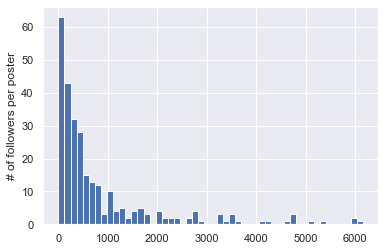

In [66]:
follower_list = list(df.num_of_followers)
follower_list.sort()
plt.hist(follower_list[:-10], bins=50)
plt.ylabel('# of followers per poster');

In [76]:
df.sort_values(by=['status_count'],ascending=False).head(10)

,user_name,user_id,num_of_followers,status_count
49,linkfinds,745712201093255200,3516,276064
5,Shasta_Otter,155477349,1559,274110
182,petermccue1,394093191,2738,250027
45,PiifernloveSJ,171407805,416,246317
119,MrSinister53,1475168784,4630,242620
192,Iheartnoise,15273924,8482,237793
265,unchangingglow,148481078,7984,211486
152,lilstur,1197589765,2174,210482
175,netstartraffic,74991659,34364,209886
221,HeatherSchultz,22029173,1509,207760


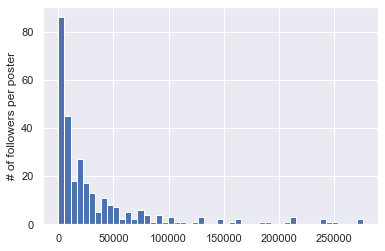

In [78]:
status_count_list = list(df.status_count)
status_count_list.sort()
plt.hist(status_count_list, bins=50)
plt.ylabel('# of status per poster');

In [84]:
# are they verified

verified_count = 0
for u in range(len(alt_filter_english)):
    if alt_filter_english[u]['user']['verified'] == True:
        verified_count = verified_count +1
        
print("n"verified_count)

4


## Quality Ratings

Next, we introduce a sample of image tweets with alt text that we previously collected and hand rated on an ordinal quality scale from 0 (Irrelevant) to 3 (Great). The levels are as follows:

0.   Irrelevant: the alt text is unrelated to content of image (often simple like "image" or spam urls)
1.   Somewhat relevant: the alt text is related to image but not descriptive. For example, an image of a golden retriever playing fetch in a field might just say "dog".
2.   Good: One or more of actors, actions, and setting are described well in the image. For the prior example, perhaps "bob, our golden retriever"
3.   Great: All of actors, actions, and setting are described well. For example, "Our golden retriever Bob is midair as he catches a frisbee in the field behind our house"

These criteria are somewhat easy to apply to photographs. For other images, we had a few additional rules. If text is in the image, it should be transcribed in the alt text. If it is a chart or graph, then information about the data in the graph (min/max, trends) should be in the alt text. You can see the whole rubric [here](https://drive.google.com/file/d/1ggNGhZwzBviz417MZH5GbV2BanYjwgmQ/view?usp=sharing). This rubric was developed based on prior work and experience working with people who use screen readers.

The rated dataset that we load containes 2024 rows, although we need to do some cleaning to remove rows that don't have all of the data we need. We also need to fetch some data for a few rows. Let's load the dataset.

In [54]:
df = pd.read_csv('hand_rated_alt_text.csv', dtype=str)
df.set_index(['tweet_id', 'image_index'], inplace=True) # a tweet can have more than one image
df['post_text'].fillna('', inplace=True) # tweets don't need to have post text, so let's treat these as empty strings
df = df[df.quality_rating.notnull()] # a few are unrated. we will remove them.
df.alt_text = df.alt_text.astype("str") # ensure all alt text has string datatype
df.quality_rating = df.quality_rating.astype("int") # treat the quality rating as an integer, not a float.
cat_dtype = pd.api.types.CategoricalDtype(categories=[0,1,2,3], ordered=True) # now change it to a categorical type
df.quality_rating = df.quality_rating.astype(cat_dtype)
df

,,sample_name,author_screenname,author_userid,post_text,image_url,alt_text,quality_rating
tweet_id,image_index,,,,,,,
1006853723027640321,0,initial_94,SmarterTravel,14132853,Seven ultra-useful carry-on bags: https://t.co...,http://pbs.twimg.com/media/DfkQH34UcAE86J6.jpg,Woman with carry-on,2
1006727264762060802,0,initial_94,endless_lands,739933308365111298,Unfinished Mountain Principality https://t.co/...,http://pbs.twimg.com/media/DfidHJbX4AA-tRf.jpg,Unfinished Mountain Principality,1
1006732469897269249,0,initial_94,robpegoraro,7301572,Mr. @tynanwrites makes a friend at #CESAsia. h...,http://pbs.twimg.com/media/DfihrWJX4AAYXZW.jpg,Dan greets a robot carrying a tray of mints.,2
1006722718111289344,0,initial_94,CarRegNG,817038404311465984,Requirements to Pass VIO Computerized Road Wor...,http://pbs.twimg.com/media/DfiY-gBW0AA8NO7.jpg,New Vehicle Reg | Change of ownership | Paper ...,0
1006826871089221633,0,initial_94,dmartw,148753316,What's this about a #raccoon climbing a skyscr...,http://pbs.twimg.com/media/Dfj3s8UWsAEk1iq.jpg,Eric Cartman from South Park dressed as The Co...,3
...,...,...,...,...,...,...,...,...
1016686645523853312,0,sample_3_no_bots,mylittlefinger,17963349,Two Green bee-eaters https://t.co/93L57wcAau,http://pbs.twimg.com/media/Dhv_DOPU8AEt0p9.jpg,Green bee-eaters,2
1007654729835601922,0,sample_3_no_bots,SmarterTravel,14132853,"A1: Beaches, of course! Some of our favorites ...",http://pbs.twimg.com/media/DfvoosQWAAIWvha.jpg,Beach sunset,2
991652298731479040,0,sample_3_no_bots,SmarterTravel,14132853,10 insanely affordable spring vacations you ca...,http://pbs.twimg.com/media/DcMOgmxW4AE6obq.jpg,Colorful Curacao,2


In [55]:
# select tweets missing author information
missing_metadata = df[df['author_userid'].isna()]
tweet_ids = missing_metadata.index.get_level_values(0).tolist()
# get tweets from twitter api
result = twitter_api.GetStatuses(tweet_ids, map=True)
# create a new data frame from this data
data = [(id,0,t.user.id_str,t.user.screen_name, t.text) for id,t in result.items() if t]
df2 = pd.DataFrame(data, columns = ['tweet_id', 'image_index', 'author_userid', 'author_screenname', 'post_text'])
df2.set_index(['tweet_id', 'image_index'], inplace=True)
# update rows of original dataframe with new data
df.update(df2)

In [56]:
# drop rows that start with urls
url = df['alt_text'].map(lambda x: x.startswith('http://') or x.startswith('https://') if type(x) == str else False)
df = df[~url]

Total remaining examples: 1980


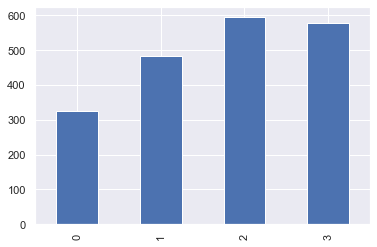

In [57]:
# Let's see a distribution of the ratings.
print(f"Total remaining examples: {len(df)}")
df.quality_rating.value_counts(sort=False).plot(kind='bar');

## Feature Extraction
Our goal is to create a classifier that can distinguish good alt text from bad alt text on this quality rating scale. This could be used to choose the best alt text from a pool of candidates, or to give feedback to the alt text author on how to improve.

We use the post text, image, and alt text in each tweet to create the features we will use for classification.

### Alt Text Perplexity
Good alt text is understandable by humans. However, some people see alt text as a place to store keywords for search engine optimization (SEO). To penalize alt text that does this, and reward well-written alt text during classification, we measure perplexity using the GPT languague model. When the alt text is well-structured and probable, perplexity will be low (closer to 0). Otherwise, perplexity will be high.  

In [58]:
import math
import random
import torch
from transformers import OpenAIGPTTokenizer, OpenAIGPTLMHeadModel
# Load pre-trained language model 
model = OpenAIGPTLMHeadModel.from_pretrained('openai-gpt')
model.eval()
# Load pre-trained model tokenizer
tokenizer = OpenAIGPTTokenizer.from_pretrained('openai-gpt')
def gpt_perplexity(sentence):
    tokenize_input = tokenizer.tokenize(sentence)
    # Because of how this GPT model is trained, the perplexity is not defined for documents with only one word. 
    # So we will set one-word alt text to have a perplexity of None for now, and we can address that later.
    if len(tokenize_input) < 2:
      return None
    tensor_input = torch.tensor([tokenizer.convert_tokens_to_ids(tokenize_input)])
    loss, logit = model(tensor_input, labels=tensor_input)
    return math.exp(loss)

In [60]:
import os
if not os.path.exists('perplexity.csv'):
  df['perplexity'] = df.apply(lambda r: gpt_perplexity(r.alt_text), axis=1)
  # save to file as it takes a while to compute
  df['perplexity'].to_csv('perplexity.csv', header=True)
else:
  perp_df = pd.read_csv('perplexity.csv', header=0, dtype='str')
  perp_df.set_index(['tweet_id', 'image_index'], inplace=True) # a tweet can have more than one image
  df['perplexity'] = perp_df['perplexity'].astype("float")

/Users/ivymew/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


### Tags Describing Images
While a full-fledged image analysis might include special features generated from a deep learning model, we chose to create simple features based on the objects/tags in the image and the text in the image.

We use the [Microsoft Cognitive Services API](https://azure.microsoft.com/en-us/services/cognitive-services/computer-vision/) to recognize tags from an image and also recognize any text in an image.

Given the image URL, the objects/tags of an image are recognized as a “bag of words” using the API. This "bag of words” includes objects, scenes, and colors recognized from the image.

In [61]:
import requests
from IPython.display import Image
from IPython.core.display import HTML 

def get_tags_and_objects(image_url):
    """Provides a caption given an image. Also includes tags, colors, dimensions, and confidence level."""
    analyze_url = "https://eastus.api.cognitive.microsoft.com/vision/v2.0/analyze"
    headers = {'Ocp-Apim-Subscription-Key': Config.msft_subscription_key}
    params = {'visualFeatures': 'Objects,Tags,Description'}
    data = {'url': image_url}
    response = requests.post(analyze_url, headers=headers,
                             params=params, json=data)
    try:
        response.raise_for_status()
    except:
        print(f"ERROR: {response.content}")
        return None
    analysis = response.json()
    rv = set(analysis["description"]['tags'])
    rv.update([o["object"] for o in analysis['objects']])
    return ' '.join(rv)

image_url = df['image_url'][0]
print(f"Tags for first image: {get_tags_and_objects(image_url)}")
Image(url=image_url,width=400)

Tags for first image: suit black building red dog bag street talking sidewalk luggage young man woman phone Luggage and bags outdoor city wearing walking holding blue cellphone meter lady suitcase standing girl carrying person


We can see the tags recognized from the above image form a list of “bag of words”, including objects, colors, and scenes in this image.

### Text in Images

Some images contain text, and that should be in the alt text as well to be a good description. We use text recognition to add these to the corpus.

In [62]:
def get_text_in_image(image_url):
    """Provides a caption given an image. Also includes tags, colors, dimensions, and confidence level."""
    analyze_url = "https://eastus.api.cognitive.microsoft.com/vision/v2.0/ocr"
    headers = {'Ocp-Apim-Subscription-Key': Config.msft_subscription_key}
    params = {}
    data = {'url': image_url}
    response = requests.post(analyze_url, headers=headers,
                             params=params, json=data)
    try:
        response.raise_for_status()
    except:
        print(f"ERROR: {response.content}")
        return None
    analysis = response.json()
    words = [w['text'] for r in analysis['regions'] for l in r['lines'] for w in l['words']]
    return ' '.join(words)
  
image_url = 'http://pbs.twimg.com/media/DgMjXuUUwAE8_dn.jpg'
print(f"Text for image: {get_text_in_image(image_url)}")
Image(url=image_url,width=400)

Text for image: CarReg.com.ng 090 9014 4706 New Vehicle Registration, Change of ownership & Vehicle particulars renewal @CarRegNG + Home Delivery


The following code uses the above functions to get the tags and text for each image and saves it in a CSV on disk. We do this so it can be easily interrupted and restarted.

In [72]:
import csv
headers = ['tweet_id', 'image_url', 'text', 'tags']

try:
    with open('image_text_and_tags.csv', 'r') as infile:
        reader = csv.reader(infile)
        next(reader)
        results = {r[1]:r for r in reader}
except:
    results = {}
    
for idx,r in df.iterrows():
    if r.image_url in results:
        continue
    tags = get_tags_and_objects(r.image_url)
    if tags == None:
        tags = ""
    else:
        tags = " ".join(tags)
    text = get_text_in_image(r.image_url)
    results[r.image_url] = (r.tweet_id, r.image_url, text, tags)
    with open('image_text_and_tags.csv', 'w') as infile:
        writer = csv.writer(infile)
        writer.writerow(headers)
        writer.writerows(results.values())

Now that this is collected, we will load it from disk and combine it with the quality rating dataset.

In [73]:
import numpy as np
image_tags_df = pd.read_csv('image_text_and_tags.csv')
image_tags_df.set_index('image_url', inplace=True)
image_tags_df.drop(['tweet_id'], axis=1, inplace=True)
image_tags_df.fillna('', inplace=True)
df_w_text = df.join(image_tags_df, on=['image_url'])
df_w_text['text_and_tags'] = df_w_text[['text', 'tags']].apply(lambda x: ' '.join(x), axis=1)
# df_w_text.drop(['text','tags'], axis=1, inplace=True)
df_w_text.replace('', np.nan, inplace=True)
df_w_text.dropna(subset=['text_and_tags', 'alt_text', 'post_text'], inplace=True)
df_w_text['text'] = df_w_text['text'].fillna('')
df_w_text['tags'] = df_w_text['tags'].fillna('')
df_w_text

,,sample_name,author_screenname,author_userid,post_text,image_url,alt_text,quality_rating,perplexity,text,tags,text_and_tags
tweet_id,image_index,,,,,,,,,,,
1006853723027640321,0,initial_94,SmarterTravel,14132853,Seven ultra-useful carry-on bags: https://t.co...,http://pbs.twimg.com/media/DfkQH34UcAE86J6.jpg,Woman with carry-on,2,82.400109,,lady woman suitcase street red building city w...,lady woman suitcase street red building city ...
1006727264762060802,0,initial_94,endless_lands,739933308365111298,Unfinished Mountain Principality https://t.co/...,http://pbs.twimg.com/media/DfidHJbX4AA-tRf.jpg,Unfinished Mountain Principality,1,407.760584,ulinter's șpire,text clock,ulinter's șpire text clock
1006732469897269249,0,initial_94,robpegoraro,7301572,Mr. @tynanwrites makes a friend at #CESAsia. h...,http://pbs.twimg.com/media/DfihrWJX4AAYXZW.jpg,Dan greets a robot carrying a tray of mints.,2,160.495615,,building standing young suit man woman people ...,building standing young suit man woman people...
1006722718111289344,0,initial_94,CarRegNG,817038404311465984,Requirements to Pass VIO Computerized Road Wor...,http://pbs.twimg.com/media/DfiY-gBW0AA8NO7.jpg,New Vehicle Reg | Change of ownership | Paper ...,0,259.129327,LAGOS STATE GOVERNMENT MINISTRY OF TRANSPORTAT...,drawing,LAGOS STATE GOVERNMENT MINISTRY OF TRANSPORTAT...
1006826871089221633,0,initial_94,dmartw,148753316,What's this about a #raccoon climbing a skyscr...,http://pbs.twimg.com/media/Dfj3s8UWsAEk1iq.jpg,Eric Cartman from South Park dressed as The Co...,3,242.611818,,toy drawing doll,toy drawing doll
...,...,...,...,...,...,...,...,...,...,...,...,...
1016686645523853312,0,sample_3_no_bots,mylittlefinger,17963349,Two Green bee-eaters https://t.co/93L57wcAau,http://pbs.twimg.com/media/Dhv_DOPU8AEt0p9.jpg,Green bee-eaters,2,377.932913,,,
1007654729835601922,0,sample_3_no_bots,SmarterTravel,14132853,"A1: Beaches, of course! Some of our favorites ...",http://pbs.twimg.com/media/DfvoosQWAAIWvha.jpg,Beach sunset,2,153172.291787,,sand track water ocean sunset nature body boat...,sand track water ocean sunset nature body boa...
991652298731479040,0,sample_3_no_bots,SmarterTravel,14132853,10 insanely affordable spring vacations you ca...,http://pbs.twimg.com/media/DcMOgmxW4AE6obq.jpg,Colorful Curacao,2,222.877526,Lüiiii,docked bridge harbor water people boat small l...,Lüiiii docked bridge harbor water people boat ...


### NLP: Text Similarity, Parts and Length of Alt Text 

From the image, alt text, and post text, we extract the following 10 features to be used by the classifier:

1.       Cosine similarity between image tags and alt text

2.       Similarity between post text and alt text

3.       Similarity between text in image and alt text

4.       (# of verbs) / (# of words) in alt text

5.       (# of adjs) / (# of words) in alt text

6.       (# of nouns) / (# of words) in alt text

7.       Number of words in alt text

8.       Number of characters in alt text

9. The perplexity of alt text as returned by the GPT language model above.

10. Whether or not text is present in the image (according to OCR).

For each sample, we construct a corpus from its image tags, alt text, post text, and text in image to perform NLP.

For feature 1, we first perform vectorization using term frequency (*tf*) for each corpus while removing stop words. Each corpus is for one sample and contains four strings: alt text, image tags, post text, and text in image (if there is no text in image, it is an empty string). URLs and unicode are removed from the corpus before vectorization. We then compute this cosine similarity using the *tf* vectors of alt text and image tags for each sample.

We decided to use term frequency (*tf*) instead of *tfidf*. This is because we do not want to lower the weights of more frequently occurring words in this small corpus, since we actually want to see the same words occurring across the alt text and image tags, or across the alt text and post text. Since we filter out stop words when performing tokenization, we do not have to rely on *idf* to take care of frequently used words in English.

For features 2 and 3, we use the spacy package to compute the document similarities between the post text and alt text, and between the text in image and alt text. The spacy package computes similarity based on word embeddings, which is useful as people may describe objects with different names. For example, the post text might be "Look at my cute pet!" and the alt text is "This is my cat, Turing"; spacy should represent "cat" and "pet" as fairly similar.

For features 4, 5, and 6, we use the spacy package to calculate the verb, adjective, and noun counts in alt text.

Features 7 and 8 are the character and word count of alt text and are easy to calculate.

Features 9 is perplexity, described above. 

Feature 10 is a binary feature that indicates if text recogntion found any alt text in the image. We include this because the alt text and image text similarity feature can be 0 for two cases: either there is text and it is completely dissimilar, or there was n text to compare. Hopefully feature 10 helps the classifier distinguish between these two cases.

We scale the values of features 6, 7, and 8 into the range of 0-1.  This is because the other features are all within the range of 0-1. To avoid the imbalance of features’ values which could cause problems in training the classifier, we perform this scaling.

In [20]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
import spacy
from collections import Counter
from sklearn import preprocessing

In [21]:
import spacy.cli
spacy.cli.download("en_core_web_lg")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [23]:
def vectorize_text_tfidf(corpus):

    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(corpus)

    tokens = vectorizer.get_feature_names()

    return X, tokens

def vectorize_text_tf(corpus):
    
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform(corpus)
    
    tokens = vectorizer.get_feature_names()
    
    return X, tokens

def create_features(alt_text, image_words_text, post_text, image_ocr, perplexity, scaler=None):
    
    nlp = spacy.load("en_core_web_lg")
    n_samples = len(alt_text)
    features_list = []
    
    # form a corpus for each image-alt_text pair
    for i in range(n_samples):
        raw_corpus = [alt_text[i], image_words_text[i], post_text[i], image_ocr[i]]
        
        # for each doc string in raw_corpus, filter out unicode and URL
        corpus = []
        for corpus_str in raw_corpus:
            if not corpus_str:
              corpus.append('')
              continue
            stripunicode = re.sub(r"[^\x00-\x7f]",r" ", corpus_str)
            removeURL = re.sub(r"https://\S+/[A-Za-z0-9]{10}", " ", stripunicode)
            removeURL1 = re.sub(r"http://\S+/[A-Za-z0-9]{10}", " ", removeURL)
            corpus.append(removeURL1)
        
        # get tf sparse matrix and tokens list
        X, tokens = vectorize_text_tf(corpus)
        alt_doc = nlp(corpus[0])
        img_tags_doc = nlp(corpus[1])
        post_doc = nlp(corpus[2])
        image_text_doc =  nlp(corpus[3])

        # compute cosine similarities
        alt_image_similarity = cosine_similarity(X[0,:], X[1,:])[0,0]
        alt_post_similarity = 0
        alt_ocr_similarity = 0
        if alt_doc.vector_norm:
          alt_post_similarity = alt_doc.similarity(post_doc) if post_doc.vector_norm else 0
          alt_ocr_similarity = alt_doc.similarity(image_text_doc) if image_text_doc.vector_norm else 0

        # get verbs, adjs, nouns, word_count, char_count of alt text
        word_list = corpus[0].split()
        word_count = len(word_list)
        text_in_img_bin = 1 if (len(corpus[3]) > 0) and (not corpus[3].isspace()) else 0
        doc = nlp(corpus[0])
        c = Counter([token.pos_ for token in doc])
        verbs = c['VERB']/word_count
        adjs = c['ADJ']/word_count
        nouns = c['NOUN']/word_count
        char_count = len(''.join(word_list))
        features_list.append(np.array([alt_image_similarity, alt_post_similarity, alt_ocr_similarity, verbs, adjs, nouns, word_count, char_count, perplexity[i], text_in_img_bin]))
        
    # scaling the word_count, char_count, and perplexity to the range of 0-1
    features_array = np.array(features_list)
    if not scaler:
      scaler = preprocessing.MinMaxScaler()
      scaler.fit(features_array[:,[6,7,8]])
    X_train_minmax = scaler.transform(features_array[:,[6,7,8]])
    features_array[:,[6,7,8]] = X_train_minmax
    
    return features_array, scaler

In [109]:
# load alt text, post text, and image words and text
alt_text = df_w_text['alt_text']
image_words_text = df_w_text['tags']
post_text = df_w_text['post_text']
image_ocr = df_w_text['text']

# if any have perplexity = None, we will set that to the highest perplexity now,
# as 1-word alt text is not a good example of well-structured sentances,
# which is essentially what we are attempting to measure here.
perplexity = df_w_text['perplexity'].fillna(np.max(df_w_text['perplexity']))

# create features, saving the min-max scaler in case we want to scale future examples
idx_array = df_w_text.index.to_list() # to keep track of samples later
features_array, scaler = create_features(alt_text, image_words_text, post_text, image_ocr, perplexity)
    
# save features array to disk so they can be easily reloaded.
np.savetxt('features.txt', features_array, fmt="%.14f")
np.savetxt('labels_multiclass.txt', df_w_text['quality_rating'], fmt="%d")

## Classification Model Selection and Training

We designed five classification models to perform model selection: Logistic Regression, SVM (linear kernel), SVM (poly kernel), SVM (rbf kernel), and Random Forest. The first two are linear classifiers while the last three are non-linear classifiers, since we want to try both linear and non-linear models. Our classifier is a multi-class classifier with four class labels (0, 1, 2, 3), each corresponding to a quality rating of alt text.

We first split our dataset into a train set and a test set in a 4:1 ratio with random shuffling. For each of the five models, we use the train set to perform 5-fold cross validation and obtain the average accuracy of the five folds. We then compare the average CV accuracy among the five models and select the model with the highest CV accuracy as our classification model.

We then train the selected model using the full train set, and evaluate the trained model using the test set to obtain the test accuracy.

For Logistic Regression, since we are dealing with a multiclass problem, we choose the ‘lbfgs’ solver to handle multinomial loss.

For SVM, we use linear, poly, and rbf kernels for three SVM models respectively. For poly kernel, we use the default degree 3. We set the kernel coefficient gamma to 'auto', which uses 1/n_features.

For Random Forest, we initially use the number of trees (n_estimators) 100, for model selection. This parameter is further tuned later.

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, cohen_kappa_score

In [78]:
def logistic_regression():
    
    logreg = LogisticRegression(
        random_state=0,
        solver='lbfgs',
        multi_class='multinomial')
    
    return logreg
    
def logistic_regression_fit(X, y):
    
    logreg = logistic_regression()
    
    logreg.fit(X, y)
    
    return logreg

def support_vector(kernel):
    # kernel: 'linear', 'poly', or 'rbf'
    # use default degree for 'poly' kernel: (default=3)
    
    svc = SVC(random_state=0, gamma='auto', kernel=kernel)
    
    return svc

def support_vector_fit(X, y, kernel):
    
    svc = support_vector(kernel)
    
    svc.fit(X, y)
    
    return svc

def random_forest(n_estimators):

    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=0)

    return rf

def random_forest_fit(X, y, n_estimators):

    rf = random_forest(n_estimators)

    rf.fit(X, y)

    return rf

def cross_validation(estimator, X, y, cv):
    
    scores = cross_validate(estimator, X, y, cv=cv, scoring='accuracy')
    
    return scores['test_score']
    

In [79]:
# load features and labels into np.array
X = np.loadtxt("features.txt")
y = np.loadtxt("labels_multiclass.txt")
print("X shape:", X.shape)
print("y shape:", y.shape)
    
# split train set and test set
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, idx_array, test_size=0.2, random_state=42)

# set up 5 models
models = {
    'Logistic Regression': logistic_regression(),
    'SVC (linear kernel)': support_vector('linear'),
    'SVC (poly kernel)': support_vector('poly'),
    'SVC (rbf kernel)': support_vector('rbf'),
    'Random Forest': random_forest(100)
}

for name, estimator in models.items():
  # perform k-fold cross validation for each model
  cv_accuracy = cross_validation(estimator, X_train, y_train, 5)
  print(f"{name}: CV average accuracy =", np.mean(cv_accuracy), "; CV fold's accuracy:", cv_accuracy)

X shape: (1932, 10)
y shape: (1932,)
Logistic Regression: CV average accuracy = 0.573462783171521 ; CV fold's accuracy: [0.61165049 0.57281553 0.55016181 0.55339806 0.57928803]
SVC (linear kernel): CV average accuracy = 0.5786407766990291 ; CV fold's accuracy: [0.59546926 0.60841424 0.5631068  0.55016181 0.57605178]
SVC (poly kernel): CV average accuracy = 0.29514563106796116 ; CV fold's accuracy: [0.29449838 0.29449838 0.29449838 0.29449838 0.29773463]
SVC (rbf kernel): CV average accuracy = 0.5812297734627832 ; CV fold's accuracy: [0.61488673 0.57605178 0.57928803 0.55016181 0.58576052]
Random Forest: CV average accuracy = 0.7372168284789644 ; CV fold's accuracy: [0.76699029 0.73786408 0.73462783 0.73462783 0.71197411]


The results are summarized in the following table:

| Model | Logistic Regression | SVM (linear kernel) | SVM (poly kernel) | SVM (rbf kernel) | Random Forest |
| --- | --- | --- | --- | --- | --- |
| CV Accuracy | 58.0% | 58.4% | 29.5% | 56.8% | **74.3%** |

Among the five models, the ensemble, non-linear model Random Forest performed the best. Thus, we chose Random Forest as our classifier. SVM (linear), Logistic Regression, and SVM (rbf) rank at the 2nd, 3rd, and 4th places respectively, and their CV accuracy is substantially lower than Random Forest’s. SVM (poly) performed the worst.

## Model Parameter Tuning

We have chosen Random Forest as our best classifier. We now further tune its model parameter: n_estimators. We perform cross validation for a range of n_estimators: 60-200, and then compare their CV accuracy. 

n_estimators 	 CV average accuracy 	 test accuracy
60 		 0.7359223300970874 	 0.751937984496124
65 		 0.7411003236245954 	 0.7571059431524548
70 		 0.7423948220064724 	 0.751937984496124
75 		 0.7391585760517799 	 0.7467700258397932
80 		 0.7423948220064724 	 0.751937984496124
85 		 0.7443365695792881 	 0.7493540051679587
90 		 0.7430420711974111 	 0.751937984496124
95 		 0.7391585760517799 	 0.7441860465116279
100 		 0.7372168284789644 	 0.7441860465116279
105 		 0.7359223300970874 	 0.7441860465116279
110 		 0.7372168284789644 	 0.7441860465116279
115 		 0.7372168284789644 	 0.7441860465116279
120 		 0.736569579288026 	 0.7467700258397932
125 		 0.7346278317152104 	 0.7467700258397932
130 		 0.7352750809061489 	 0.7441860465116279
135 		 0.7352750809061488 	 0.7467700258397932
140 		 0.7352750809061489 	 0.7441860465116279
145 		 0.7359223300970874 	 0.7467700258397932
150 		 0.7365695792880259 	 0.7467700258397932
155 		 0.7372168284789644 	 0.751937984496124
160 		 0.73915857605178

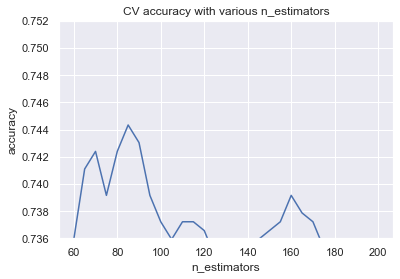

In [80]:
# perform cross validation for a range of n_estimators: 60-200
esitmator_values = []
cv_values = []
print("n_estimators \t CV average accuracy \t test accuracy")

for n_estimators in range(60, 201, 5):
    # perform k-fold cross validation for Random Forest model
    estimator = random_forest(n_estimators)
    cv_accuracy = cross_validation(estimator, X_train, y_train, 5)

    # train the Random Forest model using the train set
    clf5 = random_forest_fit(X_train, y_train, n_estimators)

    # evaluate the Random Forest model using the test set
    y_pred = clf5.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)

    print(n_estimators, "\t\t", np.mean(cv_accuracy), "\t", test_accuracy)

    esitmator_values.append(n_estimators)
    cv_values.append(np.mean(cv_accuracy))

plt.figure()
plt.plot(esitmator_values, cv_values)
plt.ylim(0.736, 0.752)
plt.xlabel("n_estimators")
plt.ylabel("accuracy")
plt.title("CV accuracy with various n_estimators")

plt.show()

In the CV accuracy curve, there is a peak around the range of 115-125 with slight fluctuations. We choose the middle point of this peak as our optimal parameter. So the optimal n_estimators = 120. We can then use this value to train our Random Forest model.

## Training and Evaluating the Chosen Classifier

Let's train the Random Forest model with the tuned parameter using the full train set, and evaluate the trained model using the test set.

In [82]:
chosen_clf = random_forest_fit(X_train, y_train, 120)
y_pred = chosen_clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Random Forest: test accuracy =", test_accuracy)

Random Forest: test accuracy = 0.7467700258397932


### Accuracy, Precision, Recall, and F1-Score

The following is the full classification report for our Random Forest model using the test set:

In [83]:
class_names = ['Irrelevant', 'Relevant', 'Good', 'Great']
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

  Irrelevant       0.91      0.85      0.88        68
    Relevant       0.63      0.63      0.63        87
        Good       0.70      0.69      0.69       127
       Great       0.80      0.85      0.82       105

    accuracy                           0.75       387
   macro avg       0.76      0.75      0.76       387
weighted avg       0.75      0.75      0.75       387



We can see the classes Irrelevant (0) and Great (3) have higher precision, recall, and f1-score than the classes Relevant (1) and Good (2). This indicates the middle classes (levels 1 and 2) perform worse than the upper and lower classes, as it is harder to distinguish between them.

### Confusion Matrix

Let's further examine this with the confusion matrix of classification result of our Random Forest model: 

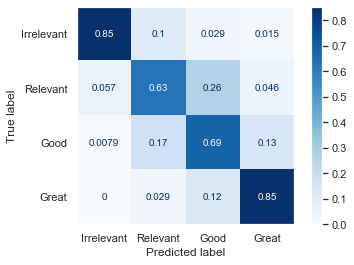

In [84]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(chosen_clf, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true');
plt.grid(None)

The light corners indicate that most misclassification is happening just up or down one level, not from one end of the scale (0) to another (3). We see the most misclassification between the levels 1 and 2, the middle classes. Our hypothesis is that these classes are not easily distinguished, even for human raters, and therefore perhaps the rubric and rating scale needs to be adjusted. Alternatively, there might be other features we can examine to help distinguish between those cases.

### Inter-Rater Reliability
When two or more people rate or label samples from a dataset, it can be useful to see how well they agree. This can be computed using a metric know as inter-rater reliability, and one version of it involves computing Cohen's Kappa \[6\]. In a binary classification task, you would compute this just using whether or not the raters agreed. As this is an ordinal rating scale, we can use weighted Cohen's Kappa, which measures the magnitude of disagreement.

For reference, when two humans applied the same rubric to this dataset, they recieved a weighted Cohen's Kappa of 0.76, which can be interpreted as substantial agreement.

We can think of our classifier as a rater, and see what inter-rater reliability it would recieve if compared to a human rater.

In [85]:
from sklearn.metrics import cohen_kappa_score
print("Weighted Cohen's Kappa =", cohen_kappa_score(y_test, y_pred, weights='linear'))

Weighted Cohen's Kappa = 0.7557294834570849


## Feature Importance

Let's look at the current feature importance ranking in our Random Forest classifier:

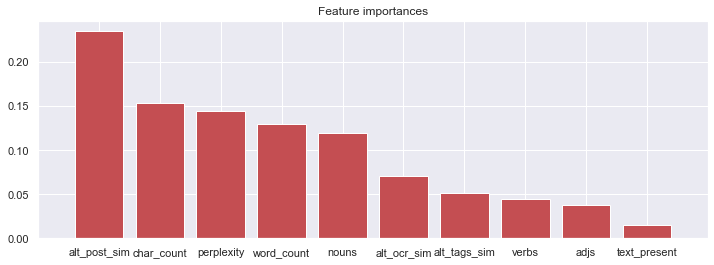

In [87]:
feature_names = ['alt_tags_sim', 'alt_post_sim', 'alt_ocr_sim', 'verbs', 'adjs', 'nouns', 'word_count', 'char_count', 'perplexity','text_present']
importances = pd.DataFrame(chosen_clf.feature_importances_,
                                   index = feature_names,
                                   columns=['importance'])
order = importances['importance'].sort_values(ascending=False)
plt.figure(figsize=(12,4))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances.loc[order.index]['importance'],
       color="r", align="center")
plt.xticks(range(X_train.shape[1]), order.index)
plt.xlim([-1, X.shape[1]])
plt.show()

Suprisingly, the similarity between the post text and the alt text is the highest feature, with almost 25% of the importance. Next we have character count, and word count is #4, both are proxies for length. It is surprising that the model finds value in both of these, as we would expect the character count to also be a good indicator of length. Perplexity ranks high as a feature as well as the percent of nouns, these are proxies for structure and coverage of objects in the alt text. All other features fall below 10% feature importance but still add some value. As not all examples contain text, it does not surprise us that those features rank low overall.

## Examining Misclassifications
To help diagnose where our classifier fails, let's investigate the misclassifications. First we will examine the most egregious case where the classifier was on the entire wrong side of the scale.

In [88]:
errors = abs((y_test - y_pred).astype(int)) # how far off the classifier was
idxs = pd.Index(np.array(idx_test)[(errors == 3)])
rows = df_w_text.loc[idxs]
rows

,,sample_name,author_screenname,author_userid,post_text,image_url,alt_text,quality_rating,perplexity,text,tags,text_and_tags
tweet_id,image_index,,,,,,,,,,,
1031879309273849856,0,sample2_bots_included,linkfinds,745712201093255168,@Shadowchaos5150 🎵 DOO DOO DOO DOO! ♩ https://...,http://pbs.twimg.com/media/DlH4wyIW4AE-aft.png,RT @chardennz: STAN TWITTER DO YOU KNOW THIS F...,0,835.003625,,man,man


Ok, there is only one example here. Let's examine the image, post text, and alt text

In [89]:
Image(url=rows.loc[idxs[0], 'image_url'])

Ah, there is nothing here because the tweet has been deleted. That lead to no tags or text being found in the image, which could be one reason it was not rated highly.

Let's move on to images where the classifier was only two levels off.

In [90]:
idxs = pd.Index(np.array(idx_test)[(errors == 2)])
rows = df_w_text.loc[idxs]
rows[['image_url', 'alt_text','text','tags','perplexity', 'quality_rating']]

,,image_url,alt_text,text,tags,perplexity,quality_rating
tweet_id,image_index,,,,,,
1039885474763026437,0,http://pbs.twimg.com/media/Dm5qPlYWsAA-vui.jpg,Lapis lazuli and lemon amber earrings,,floor lying man board sitting necklace people ...,411.244107,3
827249145576517632,0,http://pbs.twimg.com/media/C3r6RHMUYAAP0zj.jpg,"level rod in foreground, man on level gun in t...",746 5 443 2 1,dirt water people sign pole covered sitting sl...,515.496267,1
1031931873868439554,0,http://pbs.twimg.com/media/DlIokPuV4AANaO7.jpg,JESSIE TEAM ROCKET - POKEMON - JinxKittie Cos...,JINXKITTIE COSPLAY,hat woman water red board yellow white dressed...,452.865576,1
772130650312802306,0,http://pbs.twimg.com/media/Crcou6wXEAAF32p.jpg,"A cross roads store, bar, ""juke joint,"" and ga...",JAX BEST BEER AN TOWN REGAL Prince OF Dec' vs ...,store standing fire hydrant man front parked s...,137.537459,1
1031634709363810307,0,http://pbs.twimg.com/media/DlEaSbAXcAAp7x4.jpg,Judge Dredd on Lawmaster bike driving thru fire.,,large cake room lit stove sitting fire pizza k...,2578.121822,3
1007076180527341568,0,http://pbs.twimg.com/media/DfnacrbU0AAZxgm.png,@ibogost Members only. https://t.co/aWgBWasroV,,kite colorful various different Toy thing food...,1165.995835,0
1031986392182779905,0,http://pbs.twimg.com/media/DlJaJ0zWsAE291J.jpg,RT @RetroWDW: Backstage Magic #RetroWDWPhotos ...,,people computer room office bunch colorful cov...,494.280213,0
1014381132639555584,0,http://pbs.twimg.com/media/DhPODPRWsAA6OQl.jpg,Leafbird hiding in leaves.,,,211.850075,3
1018107618487951361,0,http://pbs.twimg.com/media/DiELev0XkAEnQlY.jpg,2000000km,"Pilot Earn 1,000,000 km across the distance of...",,300.054962,2


In [94]:
print('Post Text:', rows.loc[idxs[1], 'post_text'])
print('Recognizes Text:', rows.loc[idxs[1], 'text'])
print('Alt Text:', rows.loc[idxs[1], 'alt_text'])
print('Image Tags:', rows.loc[idxs[1], 'tags'])
Image(url=rows.loc[idxs[1], 'image_url'], width=200)

Post Text: Running levels this morning at 10311725 SIXMILE CYN CK AT HWY 50 NR DAYTON https://t.co/B8PFyR6vGM https://t.co/wVGPjs5w0l
Recognizes Text: 746 5 443 2 1
Alt Text: level rod in foreground, man on level gun in the background
Image Tags: dirt water people sign pole covered sitting slope outdoor snow grass holding air mountain person group hill standing man field riding skiing plane


The classifier gave this image a 3, and humans rated it a 1. I would say by the features given to it, this isn't a poor judgement. There is significant similarity due to the word "levels" and the words "rod" and "pole" probably have
close similarity. I think human raters might want more information about the scene (where is it?) that the author just didn't provide. Perhaps there should be more penalty associated with the alt text and image tags not matching?

If we want to dig in deeper on this, we can use treeinterpreter to tell us how each feature changed the predictions for each class.

In [95]:
from treeinterpreter import treeinterpreter as ti
sample_idx = np.nonzero(errors==2)[0][0]
prediction, bias, contributions = ti.predict(chosen_clf, X_test[sample_idx, :].reshape(1, -1))
print("Class priors: \t\t", np.round(bias[0],2))
print("Predictions: \t\t", np.round(prediction[0],2))
print("Feature contributions:")
chosen = np.argmax(prediction)
for c, feature in zip(contributions[0], feature_names):
  print(feature, "\t\t", np.round(c,2))

/Users/ivymew/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


Class priors: 		 [0.16 0.25 0.3  0.29]
Predictions: 		 [0.02 0.47 0.27 0.24]
Feature contributions:
alt_tags_sim 		 [ 0.01  0.04 -0.03 -0.03]
alt_post_sim 		 [ 0.02  0.21 -0.1  -0.12]
alt_ocr_sim 		 [ 0.    0.03 -0.03 -0.01]
verbs 		 [ 0.01  0.02  0.   -0.03]
adjs 		 [-0.01  0.04  0.01 -0.03]
nouns 		 [-0.07 -0.14  0.06  0.15]
word_count 		 [-0.    0.01  0.09 -0.1 ]
char_count 		 [-0.04  0.05 -0.04  0.04]
perplexity 		 [-0.05 -0.04  0.02  0.07]
text_present 		 [-0.  0. -0.  0.]


So this tells us that the biggest factors in increasing the probability of a 3 rating were: the alt text and post text similarity, the word count, and character count, and the percentage of nouns in the alt text. Basically, because this alt text was well-written and somewhat similar to the post text, it recieved a high rating.

Finally, let's look at the largest set of misclassifications: the cases where it was only off by one level. 

In [96]:
idxs = pd.Index(np.array(idx_test)[(errors == 1)])
rows = df_w_text.loc[idxs]
rows[['image_url', 'alt_text','text','tags','perplexity', 'quality_rating']]

,,image_url,alt_text,text,tags,perplexity,quality_rating
tweet_id,image_index,,,,,,
998537671977861123,0,http://pbs.twimg.com/media/DduEuAaV4AA6GfF.jpg,"Cup of coffee, map, and notebook saying ""let's...","SHXVZVY - , ,",table indoor,44.450846,2
1032080460816547840,0,http://pbs.twimg.com/media/DlKvtV-X4AA1CzY.png,cartoon,,computer window room,NaN,0
1038094063264776193,0,http://pbs.twimg.com/media/DmgNCkvU4AE70A8.jpg,"The Bean, Chicago","놏•睫§부 자4주셔사뼌까 프:」彎三E,글일뇨,-크넣:",bridge tall water people street large sign bui...,4937.633925,1
1026914171613536257,0,http://pbs.twimg.com/media/DkBU-NsW0AE1sVF.jpg,Another pub called the Islington,"04. ra D/D/RR/ azag UPSE,"" RHYTHM • L/W/CS z i...",building text clock station bench hanging blac...,174.179212,1
967564628610965504,0,http://pbs.twimg.com/media/DW165mPX4AEWyL_.jpg,"FHA low income housing project. Holyoke, Massa...",,woman people house street small large sign bui...,1095.954624,2
...,...,...,...,...,...,...,...
1025066067914149888,0,http://pbs.twimg.com/media/DjnEG7iV4AAKWM0.jpg,Therein Lie Hierarchy Dost Denounce of ? Thoma...,English 4) ENGLISH 0 100% 09:45 AM Latin x The...,screenshot text abstract,9405.534519,1
883741492426178560,0,http://pbs.twimg.com/media/DEOtSxJXgAASa41.jpg,"Nikki Haley quotation from linked article, re:...","Another U.S. official, Nikki Haley, the U.S. A...",screenshot,238.889538,2
993612721533931521,0,http://pbs.twimg.com/media/DcoFgLjXUAEJk10.jpg,Hiking near Mt. Hood,,dirt trail wood sign red country tree forest s...,629.947668,1


Since there are 88 of these, we will again only examine the first in depth.

In [97]:
row = rows.loc[idxs[0]]
sample_idx = np.nonzero(errors==1)[0][0]
print('Post Text:',  row.post_text[0])
print('Recognized Text:', row.text[0])
print('Alt Text:', row.alt_text[0])
print('Image Tags:', row.tags[0])
print('Expected Rating: ', y_test[sample_idx], 'Predicted Rating:', y_pred[sample_idx])
Image(url=row.image_url[0], width=400)

Post Text: The seven cities where you can find the world's best coffee: https://t.co/oxPMr7L1Wj https://t.co/SunVcMudOB
Recognized Text: SHXVZVY - , ,
Alt Text: Cup of coffee, map, and notebook saying "let's go"
Image Tags: table indoor
Expected Rating:  2.0 Predicted Rating: 3.0


/Users/ivymew/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Human rates did not give this a 3 because it did not describe what kind of map it was or the other objects on the table. However, the given alt text is not bad, so it does not seem unreasonable to give it a 3. That is likely the cases for many of these where the image and alt text inhabit a border area between classes. Perhaps they are not exactly a 2 or 3, or humans mislabelled them.

Let's still investigate what contributed to this rating.

In [98]:
prediction, bias, contributions = ti.predict(chosen_clf, X_test[sample_idx, :].reshape(1, -1))
print("Class priors: \t\t", np.round(bias[0],2))
print("Predictions: \t\t", np.round(prediction[0],2))
print("Feature contributions:")
chosen = np.argmax(prediction)
for c, feature in zip(contributions[0], feature_names):
    print(feature, "\t\t", np.round(c,2))

Class priors: 		 [0.16 0.25 0.3  0.29]
Predictions: 		 [0.08 0.05 0.35 0.52]
Feature contributions:
alt_tags_sim 		 [ 0.    0.01  0.01 -0.02]
alt_post_sim 		 [-0.04 -0.01 -0.01  0.06]
alt_ocr_sim 		 [ 0.02  0.01 -0.05  0.02]
verbs 		 [ 0.02 -0.04  0.05 -0.03]
adjs 		 [ 0.    0.02  0.02 -0.04]
nouns 		 [-0.03 -0.08 -0.03  0.14]
word_count 		 [-0.04 -0.04  0.01  0.07]
char_count 		 [-0.02 -0.   -0.02  0.04]
perplexity 		 [-0.   -0.06  0.06  0.01]
text_present 		 [ 0.    0.    0.01 -0.01]


The classifier only assigned 53% of probability to the 3 rating, and still had a significant probability given to the 2 rating. What is interesting is none of the features stand out as dominating here. The percent of nouns is the highest contributor to the 3 rating, followed, by a tie between word count, character count, and perplexity. 

This may indicate that cases where the misclassification is only 1 class away do not have a dominating feature that leads to their misclassification, they just have an accumulation of classes that are on the edge.

## Using the Classifier to Automatically Grade Alt Text

We now have our classifier trained, and we can use it to automatically grade new alt text.

We will take a new image and try different alt texts.

In [105]:
def evaluate_alt_text(model, post_text, image_url, alt_text):
    text = get_text_in_image(image_url)
    tags = get_tags_and_objects(image_url)
    perplexity = gpt_perplexity(alt_text)
    if perplexity == None:
        perplexity = df_w_text['perplexity'].max()
    if text == None:
        text = ""
    print("Post text: ", post_text)
    print("Alt text: ", alt_text)
    print("Image tags: ", tags)
    print("Image text: ", text)
    X, _ = create_features([alt_text], [tags], [post_text], [text], [perplexity], scaler=scaler)
    return X,model.predict(X)[0]

image_url = "https://pbs.twimg.com/media/EF-l-ocVAAES7DW?format=jpg&name=medium"
post_text = """The dog being cute. Quite comfortable, thank you very much. 
Upside down on the only couch he's allowed on. He wants, err, no, DEMANDS, a tummy rub!"""
Image(url=image_url, width=400)

Ok, let's design some bad alt text. Most that look like this do not even describe the image. Twitter, for example, says "image" for all alt text that are empty.

## Discussion and Future Work

One of the most straightforward applications of our project is to provide users with on-the-fly feedback about how to draft a better description to the pictures they posted. 
the classifier can not only provide a rating (which could be turned into an indicator similar to "password strength" metrics), but the feature contributions can be used to detail specifically what to improve. For example:

*   If char_count or word_count are shifting probability mass to low ratings, say "Try writing some more! Longer alt text tends to be more descriptive!"
*   If "alt_tags_sim" is moving probability mass to low ratings, say "We see some more things in the image that could be described! What does the dog look like?"

Given the result from our feature importance, it is crucial that the image and post text combine to become a coherent story for visually-impaired users to grasp. In addition, users are encouraged to use nouns to give a more vivid narrative to thes images. 

The biggest limitation with this work is the quality-ratings in the dataset. Many of the edge-cases may be mislabelled by humans, or they do not clearly belong to a single class. This may be misleading our classifier. In addition, these images and alt text pairs were rated by sighted researchers, and their notions of quality may not reflect what people with vision impairments desire. 

Therefore, future work should examine how to validate this quality scale with visually impaired Twitter users. Additionally, future uses of a dataset like this should validate the ratings among many human raters, and perhaps take the most common rating or further investigate samples where raters cannot agree.



## Conclusion

This project demonstrated how to pull information from the Twitter API and examined a dataset of tweets containing alternative text for people with vision impairments. Then, using quality ratings on a 4-level scale, we set out to create a classifier that can automatically grade alternative text. We extracted 10 features from the tweet post text, image, and alternative text present. We then performed model selection, finding a random forsent to be the best-performing model for this task. After model selection, tuning, and training, we examined the feature importance and classification results, finding that the classifier can rate these levels with 75% accuracy.